In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

print(torch.cuda.get_device_name())
print(torch.__version__, torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

NVIDIA RTX A2000 8GB Laptop GPU
2.0.0+cu118 True
cuda:0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [46]:

x_data = np.loadtxt('../data/env1/x.csv', delimiter=',',encoding="utf-8-sig")
y_data = np.loadtxt('../data/env1/y.csv', delimiter=',',encoding="utf-8-sig")
theta_data = np.loadtxt('../data/env1/theta.csv', delimiter=',',encoding="utf-8-sig")
"""
x_data = np.loadtxt('../data/env2/x.csv', delimiter=',',encoding="utf-8-sig")
y_data = np.loadtxt('../data/env2/y.csv', delimiter=',',encoding="utf-8-sig")
theta_data = np.loadtxt('../data/env2/theta.csv', delimiter=',',encoding="utf-8-sig")

x_data = np.loadtxt('../data/env1/x_extract.csv', delimiter=',',encoding="utf-8-sig")
y_data = np.loadtxt('../data/env1/y_extract.csv', delimiter=',',encoding="utf-8-sig")
theta_data = np.loadtxt('../data/env1/theta_extract.csv', delimiter=',',encoding="utf-8-sig")
"""

'\nx_data = np.loadtxt(\'../data/env2/x.csv\', delimiter=\',\',encoding="utf-8-sig")\ny_data = np.loadtxt(\'../data/env2/y.csv\', delimiter=\',\',encoding="utf-8-sig")\ntheta_data = np.loadtxt(\'../data/env2/theta.csv\', delimiter=\',\',encoding="utf-8-sig")\n\nx_data = np.loadtxt(\'../data/env1/x_extract.csv\', delimiter=\',\',encoding="utf-8-sig")\ny_data = np.loadtxt(\'../data/env1/y_extract.csv\', delimiter=\',\',encoding="utf-8-sig")\ntheta_data = np.loadtxt(\'../data/env1/theta_extract.csv\', delimiter=\',\',encoding="utf-8-sig")\n'

In [33]:
x_data_input = np.stack([x_data[:, 0],x_data[:, -1]], axis=1)
y_data_input = np.stack([y_data[:, 0],y_data[:, -1]], axis=1)
theta_data_input = np.stack([theta_data[:, 0],theta_data[:, -1]], axis=1)

x_data_output = x_data[:, 1:-1]
y_data_output = y_data[:, 1:-1]

In [34]:
input_data = np.concatenate([x_data_input, y_data_input, theta_data_input], axis=1)
output_data = np.concatenate([x_data_output, y_data_output], axis=1)

print(input_data)
print(output_data)

[[ 3.19393316 26.39875157 -1.91280395 -2.31644014 -0.84273024  0.55861484]
 [ 2.72943306 28.42131502  0.61612217 -1.5084224   1.00727544 -1.32000793]
 [-0.57183403 27.29676244 -0.45290591 -1.52252911  0.78680988  0.14739377]
 ...
 [ 2.35658391 30.50816895 -1.5458434  -0.40211897 -0.77622738  0.1658102 ]
 [ 0.53227556 27.74226378  1.18407679 -0.35504202 -1.04818083 -1.36028346]
 [ 3.79315855 29.50668667 -0.15362667  2.35930441  0.63152715  1.17514914]]
[[ 3.47283178  4.2730657   5.11246094 ... -3.47095662 -3.12902914
  -2.74722562]
 [ 2.97577858  3.6956368   4.54771857 ...  1.45733805  0.69721934
  -0.20474688]
 [-0.1354571   0.70155071  1.60509283 ... -2.06987185 -1.88457129
  -1.69747082]
 ...
 [ 2.76300566  3.71362397  4.73340957 ... -1.02727936 -0.8045078
  -0.59586525]
 [ 0.53227556  1.44365564  3.06081017 ...  2.53650065  1.85792899
   1.02647255]
 [ 4.40570252  5.12251826  5.85457686 ...  2.24526407  1.5706258
   1.5706258 ]]


In [35]:
"""
#input_dataに対して最小最大スケーリングを行う
input_data_normalized = (input_data - np.min(input_data, axis=0)) / (np.max(input_data, axis=0) - np.min(input_data, axis=0))
print(input_data_normalized)
"""

'\n#input_dataに対して最小最大スケーリングを行う\ninput_data_normalized = (input_data - np.min(input_data, axis=0)) / (np.max(input_data, axis=0) - np.min(input_data, axis=0))\nprint(input_data_normalized)\n'

In [36]:
class MyDataset(Dataset):
    def __init__(self, input_data, output_data):
        super(MyDataset, self).__init__()
        self.input_data = input_data
        self.output_data = output_data

    def __getitem__(self, index):
        input = torch.tensor(self.input_data[index], dtype=torch.float32)
        output = torch.tensor(self.output_data[index], dtype=torch.float32)
        return input, output

    def __len__(self):
        return len(self.input_data)

In [37]:
train_valid_data = MyDataset(input_data, output_data)

val_size = int(0.2 * len(train_valid_data))
train_data, val_data = torch.utils.data.random_split(train_valid_data, [len(train_valid_data)-val_size, val_size])

In [38]:
val_size

1264

In [39]:
train_data[0]

(tensor([ 3.7455, 27.8834,  0.6830, -1.7154,  0.1391,  0.2794]),
 tensor([ 4.0648,  5.0276,  5.8099,  6.5335,  7.2564,  8.0476,  9.8231, 11.1920,
         11.9661, 12.6613, 13.3133, 13.9396, 14.5537, 15.1680, 15.7963, 16.4567,
         17.1818, 18.0803, 19.2855, 20.2242, 21.1232, 22.0011, 22.8669, 23.7243,
         24.5750, 25.4173, 26.2461, 27.0644,  0.7277,  0.8625,  1.0842,  1.3362,
          1.6084,  1.9048,  2.4955,  2.2908,  1.9421,  1.5639,  1.1659,  0.7546,
          0.3335, -0.0955, -0.5314, -0.9745, -1.4289, -1.9266, -2.4263, -2.5984,
         -2.6777, -2.6915, -2.6535, -2.5723, -2.4541, -2.3045, -2.1293, -1.9327]))

In [40]:
batch_size = 64

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

In [41]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [42]:
# ハイパーパラメータの設定
input_size = input_data.shape[1]
hidden_size = 2000
output_size = output_data.shape[1]
learning_rate = 0.001
num_epochs = 100

# モデルの定義
model = MLP(input_size, hidden_size, output_size).to(device)

In [43]:
# 損失関数の定義
criterion = nn.MSELoss()

# オプティマイザの定義
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#トレーニングの開始
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    
    #train_mode
    model.train()
    for i, (input_data, output_data) in enumerate(dataloader_train):
        # データをGPUに転送
        input_data, output_data = input_data.to(device), output_data.to(device)
        
        # モデルの出力を計算
        output = model(input_data.view(-1, input_size))
        
        # 損失関数の適用
        loss = criterion(output, output_data)
        
        #train_lossに結果を蓄積
        train_loss += loss.item()
        
        # 勾配を初期化して逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # lossの平均を計算
        avg_train_loss = train_loss / len(dataloader_train.dataset)  
        
    #valid_mode
    model.eval()
    with torch.no_grad():
        for input_data, output_data in dataloader_valid:
            # データをGPUに転送
            input_data, output_data = input_data.to(device), output_data.to(device)
            
            # モデルの出力を計算
            output = model(input_data.view(-1, input_size))
            
            # 損失関数の適用
            loss = criterion(output, output_data)
        
            #val_lossに結果を蓄積
            val_loss += loss.item()
    
    # lossの平均を計算      
    avg_val_loss = val_loss / len(dataloader_valid.dataset)
    
    # print log
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}'.format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss))
    
    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)



Epoch [1/100], Loss: 0.5709, val_loss: 0.1053
Epoch [2/100], Loss: 0.0993, val_loss: 0.0822
Epoch [3/100], Loss: 0.0521, val_loss: 0.0429
Epoch [4/100], Loss: 0.0411, val_loss: 0.0578
Epoch [5/100], Loss: 0.0380, val_loss: 0.0355
Epoch [6/100], Loss: 0.0307, val_loss: 0.0274
Epoch [7/100], Loss: 0.0279, val_loss: 0.0291
Epoch [8/100], Loss: 0.0282, val_loss: 0.0273
Epoch [9/100], Loss: 0.0279, val_loss: 0.0278
Epoch [10/100], Loss: 0.0257, val_loss: 0.0360
Epoch [11/100], Loss: 0.0271, val_loss: 0.0258
Epoch [12/100], Loss: 0.0274, val_loss: 0.0281
Epoch [13/100], Loss: 0.0260, val_loss: 0.0321
Epoch [14/100], Loss: 0.0261, val_loss: 0.0390
Epoch [15/100], Loss: 0.0259, val_loss: 0.0245
Epoch [16/100], Loss: 0.0244, val_loss: 0.0272
Epoch [17/100], Loss: 0.0260, val_loss: 0.0241
Epoch [18/100], Loss: 0.0239, val_loss: 0.0241
Epoch [19/100], Loss: 0.0257, val_loss: 0.0289
Epoch [20/100], Loss: 0.0250, val_loss: 0.0305
Epoch [21/100], Loss: 0.0244, val_loss: 0.0405
Epoch [22/100], Loss: 

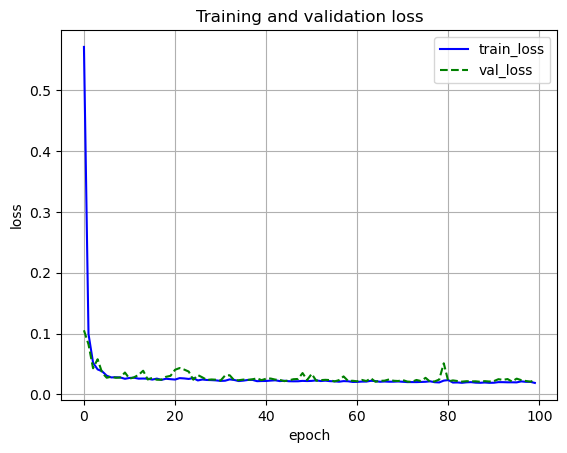

In [44]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

In [45]:
#save model
torch.save(model.state_dict(), '../saved_models/MLP_env1_first_quantile.pth')

In [53]:
#read model
model = MLP(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load('../saved_models/MLP_env1_extract.pth'))
print(model)

MLP(
  (fc1): Linear(in_features=6, out_features=2000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2000, out_features=2000, bias=True)
  (fc3): Linear(in_features=2000, out_features=56, bias=True)
)


In [54]:
class TestDataset(Dataset):
    def __init__(self, test_data):
        self.test_data = test_data

    def __len__(self):
        return len(self.test_data)

    def __getitem__(self, index):
        input = torch.tensor(self.test_data[index], dtype=torch.float32)
        output = 0
        return input, output

初期姿勢：-65°, 終端姿勢：44°
True


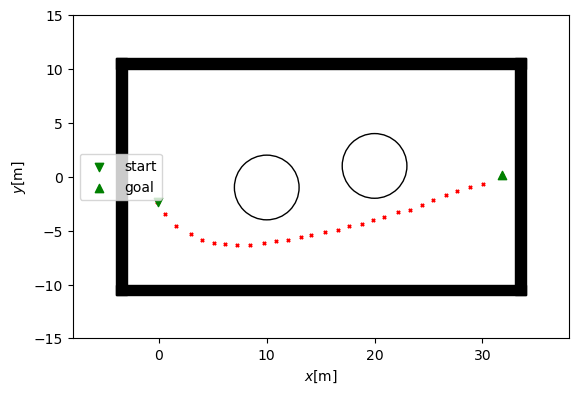

In [57]:
#test_pathの表示
import plot
import random
import utils

#入力のサンプリング
x_start = (random.uniform(-2, 4), random.uniform(-3, 3))  # Starting node
x_goal = (random.uniform(26, 32), random.uniform(-3, 3))  # Goal node

theta_start = random.uniform(-np.pi/2, np.pi/2)
theta_goal = random.uniform(-np.pi/2, np.pi/2)

test_data = np.array([[x_start[0], x_goal[0], x_start[1], x_goal[1], theta_start, theta_goal]])

"""
#正規化する
input_data = np.concatenate([x_data_input, y_data_input, theta_data_input], axis=1)
test_data = (test_data - np.min(input_data, axis=0)) / (np.max(input_data, axis=0) - np.min(input_data, axis=0))
"""

test_data = TestDataset(test_data)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

#予測モード
model.eval()
with torch.no_grad():
    input_data, _ = next(iter(test_loader))
    input_data = input_data.to(device)
    output = model(input_data)
    output = output.view(2, -1)

    
output = output.cpu().numpy()
test_x_path = np.append(output[0], x_goal[0])
test_x_path = np.append(x_start[0], test_x_path)
test_y_path = np.append(output[1], x_goal[1])
test_y_path = np.append(x_start[1], test_y_path)
print("初期姿勢：{}°, 終端姿勢：{}°".format(int(np.degrees(theta_start)), int(np.degrees(theta_goal))))
print(utils.is_collision_free(test_x_path, test_y_path))
plot.vis_path_env1(test_x_path, test_y_path)